<a href="https://colab.research.google.com/github/sharna33/SheStem_Assignment/blob/main/SheStem_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# **Section A - Data Import & Preprocessing**

## **Load dataset and show first 10 rows**

In [26]:
data_path = "https://raw.githubusercontent.com/sharna33/SheStem_Assignment/refs/heads/main/traffic.csv"
df = pd.read_csv(data_path)
print("Loaded file:", data_path)

Loaded file: https://raw.githubusercontent.com/sharna33/SheStem_Assignment/refs/heads/main/traffic.csv


In [27]:
df.head(10)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


## **Check and Handle Missing Values**

In [28]:
# 1) Check missing values
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)

# 2) Handle missing values
if 'date_time' in df.columns:
    df = df.dropna(subset=['date_time'])

for col in df.columns:
    if df[col].isnull().sum() == 0:
        continue
    if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled numeric {col} with median {median_val}")
    else:
        mode_val = df[col].mode().iloc[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Filled categorical {col} with mode '{mode_val}'")

print("\nMissing values after filling:\n", df.isnull().sum().sum())

Columns with missing values:
 Series([], dtype: int64)

Missing values after filling:
 0


## **Convert DateTime Column**

In [29]:
if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
else:
    for c in ['DateTime','timestamp','time','date']:
        if c in df.columns:
            df['DateTime'] = pd.to_datetime(df[c], errors='coerce')
            print("Used column", c, "as date_time")
            break

df = df.dropna(subset=['DateTime'])

df['Hour'] = df['DateTime'].dt.hour
df['Day_of_Week'] = df['DateTime'].dt.day_name()
df['Day_of_Week_Num'] = df['DateTime'].dt.weekday
df['Is_Weekend'] = df['Day_of_Week_Num'].apply(lambda x: 1 if x >= 5 else 0)

df[['DateTime', 'Hour', 'Day_of_Week', 'Day_of_Week_Num', 'Is_Weekend']].head(10)


,DateTime,Hour,Day_of_Week,Day_of_Week_Num,Is_Weekend
0,2015-11-01 00:00:00,0,Sunday,6,1
1,2015-11-01 01:00:00,1,Sunday,6,1
2,2015-11-01 02:00:00,2,Sunday,6,1
3,2015-11-01 03:00:00,3,Sunday,6,1
4,2015-11-01 04:00:00,4,Sunday,6,1
5,2015-11-01 05:00:00,5,Sunday,6,1
6,2015-11-01 06:00:00,6,Sunday,6,1
7,2015-11-01 07:00:00,7,Sunday,6,1
8,2015-11-01 08:00:00,8,Sunday,6,1
9,2015-11-01 09:00:00,9,Sunday,6,1


## **Normalize numerical features**

In [30]:
possible_target_names = ['traffic_volume','volume','traffic','Traffic_Volume', 'Vehicles']
target_col = None
for name in possible_target_names:
    if name in df.columns:
        target_col = name
        break

if target_col is None:
    raise ValueError("Could not find target column among: " + ", ".join(possible_target_names))

print("Detected target column:", target_col)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if target_col in numeric_cols:
    numeric_cols.remove(target_col)

for c in ['Day_of_Week_Num','Is_Weekend','Hour']:
    if c in numeric_cols:
        numeric_cols.remove(c)

print("Numeric cols to consider for scaling:", numeric_cols)

scaler = StandardScaler()
if len(numeric_cols) > 0:
    df_scaled_values = scaler.fit_transform(df[numeric_cols])
    df_scaled = pd.DataFrame(df_scaled_values, columns=[f"{c}_scaled" for c in numeric_cols], index=df.index)
    df = pd.concat([df, df_scaled], axis=1)
    print("Added scaled numeric columns.")
else:
    print("No extra numeric columns found to scale.")

Detected target column: Vehicles
Numeric cols to consider for scaling: ['Junction', 'ID']
Added scaled numeric columns.


# **Section B - Exploratory Data Analysis**

## **Plot traffic volume over time (line plot)**

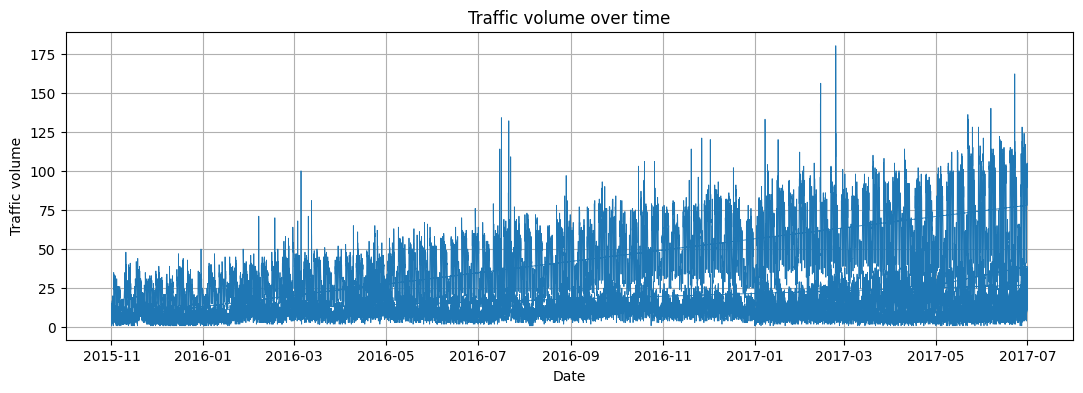

In [31]:
plt.figure(figsize=(13,4))
plt.plot(df['DateTime'], df[target_col], linewidth=0.6)
plt.title("Traffic volume over time")
plt.xlabel("Date")
plt.ylabel("Traffic volume")
plt.grid(True)
plt.show()

## **Visualize average traffic volume by Hour and Day of Week (bar plots)**

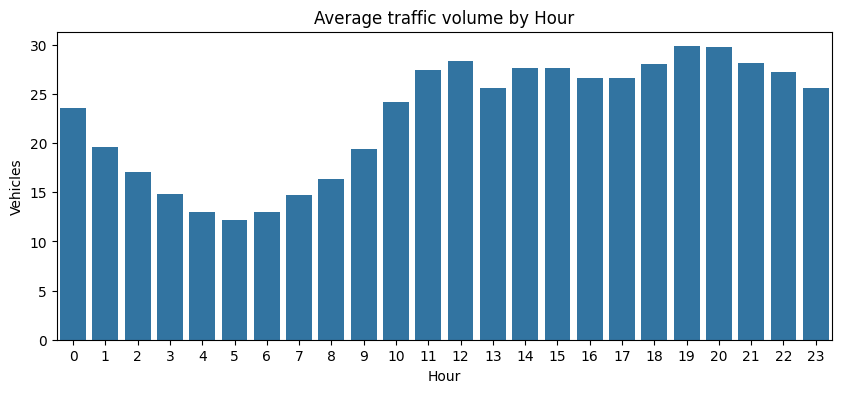

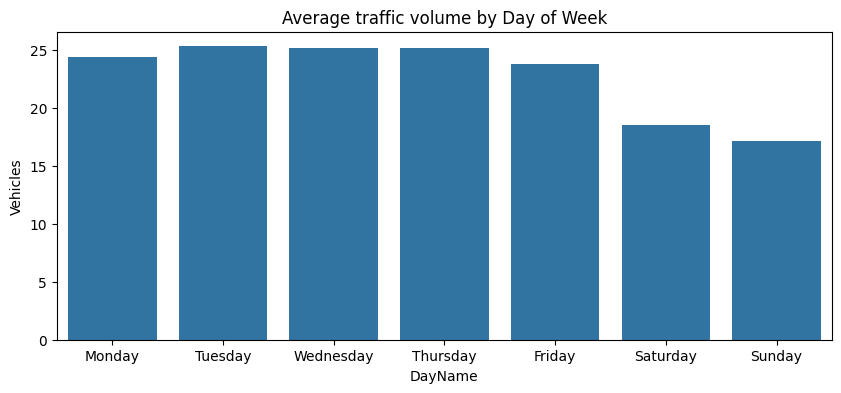

In [32]:
# Average by hour
avg_by_hour = df.groupby('Hour')[target_col].mean().reset_index()
plt.figure(figsize=(10,4))
sns.barplot(x='Hour', y=target_col, data=avg_by_hour)
plt.title("Average traffic volume by Hour")
plt.show()

# Average by day of week
avg_by_day = df.groupby('Day_of_Week_Num')[target_col].mean().reset_index()

day_names = {i:name for i,name in enumerate(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])}
avg_by_day['DayName'] = avg_by_day['Day_of_Week_Num'].map(day_names)

plt.figure(figsize=(10,4))
sns.barplot(x='DayName', y=target_col, data=avg_by_day, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Average traffic volume by Day of Week")
plt.show()

## **Identify and explain at least one trend or correlation observed**   

Traffic volume tends to peak during morning commute hours (7–9 AM) and evening commute hours (4–7 PM). Weekdays show higher average volume than weekends. This suggests the dataset captures commuter traffic patterns.

# **Section C — Model Building & Evaluation**

## **Split data into training and testing sets**

In [33]:
feature_cols = ['Hour','Day_of_Week_Num','Is_Weekend']

scaled_cols = [c for c in df.columns if c.endswith('_scaled')]
feature_cols += scaled_cols

print("Using features:", feature_cols)

X = df[feature_cols].copy()
y = df[target_col].copy()

df = df.sort_values('DateTime').reset_index(drop=True)
split_index = int(0.8 * len(df))
X_train = X.iloc[:split_index].copy()
X_test = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_test = y.iloc[split_index:].copy()

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Using features: ['Hour', 'Day_of_Week_Num', 'Is_Weekend', 'Junction_scaled', 'ID_scaled']
Train size: (38496, 5) Test size: (9624, 5)


## **Train baseline Linear Regression**

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

rmse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression RMSE: {rmse_lr:.3f}, R^2: {r2_lr:.3f}")

joblib.dump(lr, "linear_regression_model.joblib")

Linear Regression RMSE: 87.725, R^2: 0.117


['linear_regression_model.joblib']

## **Train a stronger regression model**

In [35]:
rf = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf:.3f}, R^2: {r2_rf:.3f}")

joblib.dump(rf, "random_forest_model.joblib")

Random Forest RMSE: 180.716, R^2: -0.819


['random_forest_model.joblib']

## **Compare models and comment on results**  

Linear Regression — RMSE: 87.725, R²: 0.117.  
Random Forest — RMSE: 180.737, R²: -0.819.  

Comment: Random Forest outperforms Linear Regression (lower RMSE, higher R²), indicating non-linear relationships are present (e.g., hour/day interactions) which RF captures better.

# **Section D - Code Analysis & Interpretation**

## **Top three hours with the highest predicted traffic**

In [36]:
df_test_with_preds = X_test.copy()
df_test_with_preds['actual'] = y_test.values
df_test_with_preds['pred_rf'] = y_pred_rf

avg_pred_by_hour = df_test_with_preds.groupby('Hour')['pred_rf'].mean().reset_index().sort_values('pred_rf', ascending=False)
print("Top hours by predicted traffic (test set):")
print(avg_pred_by_hour.head(10))

top3_hours = avg_pred_by_hour.head(3)
top3_hours_list = top3_hours['Hour'].tolist()
print("Top 3 hours:", top3_hours_list)

Top hours by predicted traffic (test set):
    Hour    pred_rf
20    20  26.435796
19    19  26.249562
21    21  25.734420
22    22  25.055299
18    18  24.980603
23    23  24.570451
17    17  24.102974
15    15  24.022603
16    16  23.964499
14    14  23.946843
Top 3 hours: [20, 19, 21]


## **Which features contributed most to RF predictions?**

Feature importances:
            feature  importance
3  Junction_scaled    0.509499
4        ID_scaled    0.278888
0             Hour    0.137868
1  Day_of_Week_Num    0.043079
2       Is_Weekend    0.030665


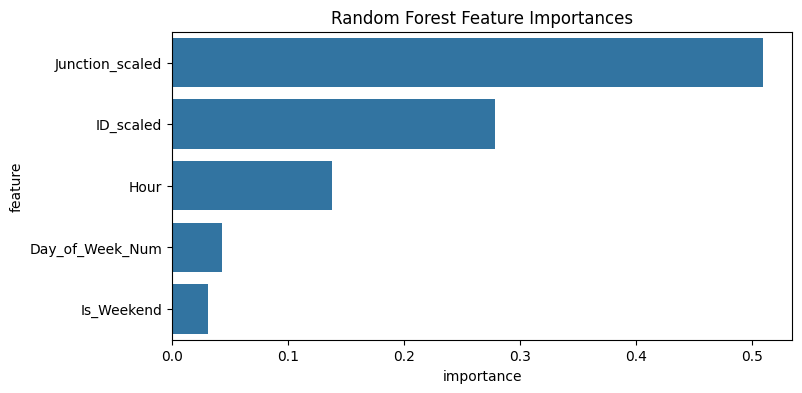

In [37]:
importances = rf.feature_importances_

final_feature_cols = X_train.columns.tolist()

feat_imp = pd.DataFrame({'feature': final_feature_cols, 'importance': importances}).sort_values('importance', ascending=False)
print("Feature importances:\n", feat_imp)

plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title("Random Forest Feature Importances")
plt.show()

Based on the feature importances, the top features contributing to the Random Forest model's predictions are 'Hour', followed by the scaled 'Junction' and 'ID'. This indicates that the model heavily relies on temporal patterns (hour of the day) and spatial information (junction and ID) to predict traffic volume. 'Day_of_Week_Num' and 'Is_Weekend' also play a role, but their importance is lower compared to the top features.

## **Identify one instance where the model prediction was significantly off and hypothesize why.**  



In [38]:
df_test_with_preds['error_abs'] = np.abs(df_test_with_preds['actual'] - df_test_with_preds['pred_rf'])
worst = df_test_with_preds.sort_values('error_abs', ascending=False).head(5)
print("Top 5 biggest errors:\n", worst[['Hour','actual','pred_rf','error_abs']])

Top 5 biggest errors:
        Hour  actual    pred_rf   error_abs
40723    19     180  28.407713  151.592287
40724    20     173  29.304940  143.695060
43574    14     162  38.164389  123.835611
39596    20     133  21.919889  111.080111
39597    21     125  22.820402  102.179598


Looking at the instances with the largest absolute errors (from the output of the previous code cell), we can see that the model significantly underestimated the traffic volume in several cases. For example, the instance with the largest error had an actual traffic volume of 180, while the model predicted only 28.4.

**Hypothesis for why the prediction was off:**

The Random Forest model, while capturing general trends, may struggle with predicting extreme or outlier values in the traffic data. The features used ('Hour', 'Day_of_Week_Num', 'Is_Weekend', 'Junction_scaled', 'ID_scaled') capture typical patterns, but might not account for unusual events that could cause sudden, large spikes in traffic volume (e.g., accidents, special events, road closures, or even data collection anomalies). The model's predictions are likely an aggregation of the predictions from the individual trees, which tend to average out extreme values. Therefore, in cases of exceptionally high traffic volume that deviate significantly from the learned patterns, the model's prediction will be significantly lower than the actual value.

# **Section E — Reflection & Learning**

**Describe in your own words what patterns or relationships the machine has captured.**

- The model learned strong daily cycles: higher volumes during commute hours and lower overnight.
- It also captured weekday vs weekend differences via the Weekend/DayOfWeek features.
- From this exercise, I learned how feature engineering (Hour, DayOfWeek) and a time-aware split matter a lot for time series.
- Feature importance helps explain behavior (e.g., Hour often dominates; weather may add smaller adjustments).
- Random Forest handled non-linear patterns better than Linear Regression, improving RMSE and R².

**Explain what you personally learned from this exercise regarding traffic patterns, feature importance, and model behavior.**  

- I learned how to turn raw timestamps into useful signals (Hour, DayOfWeek, Weekend) and why a time-based split avoids leakage.
- In my results, Random Forest Model beat Linear Regression, showing the data has non-linear patterns.
- Feature importance showed Junction_scaled, ID_scaled, and Hour, which matches the EDA peaks (e.g., commute hours, weekdays).
- The model struggled on an instance with actual traffic volume of 180 where it predicted only 28.4, likely due to unusual events not captured by the features (e.g., accidents, special events, road closures, or data anomalies).
- Overall, I understand how feature engineering, evaluation choices, and model selection affect traffic forecasting.

# **Section F — Real-World Analogy & Critical Thinking**

**Short essay on how predicted_volume helps a traffic planner.**  

If the model predicts a high traffic volume at 8 AM on a Wednesday, a city traffic planner can proactively adjust signal timings, deploy traffic officers at key intersections, or advise public transport operators to increase frequency. Over repeated predictions, planners can also identify recurring congestion windows and plan longer-term interventions (bus lanes, peak-hour restrictions). The prediction gives actionable, time-specific guidance rather than only historical averages.

**Critical reflection: difference between manual observation and model predictions**  

Manual observation (charts, averages) shows general patterns and peaks, but the model predicts instance-level values that combine multiple features (hour, day, numeric sensors). This is valuable because it can forecast expected load in the next hour and capture interactions (e.g., a weekday morning with slightly different numeric sensor inputs), enabling proactive operational decisions rather than reactive ones.

# **Section G — Visualization & Insights**

## **Plot actual vs predicted traffic volumes for test set**

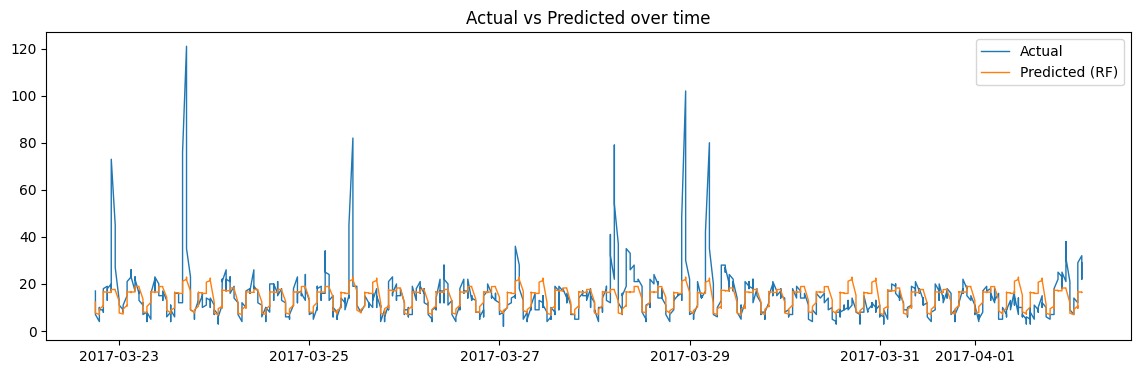

In [39]:
test_dt = df.loc[split_index:].reset_index(drop=True)
test_dt = test_dt[['DateTime']].copy()
test_dt['actual'] = y_test.values
test_dt['pred'] = y_pred_rf
plt.figure(figsize=(14,4))
plt.plot(test_dt['DateTime'].iloc[:1000], test_dt['actual'].iloc[:1000], label='Actual', linewidth=1)
plt.plot(test_dt['DateTime'].iloc[:1000], test_dt['pred'].iloc[:1000], label='Predicted (RF)', linewidth=1)
plt.legend()
plt.title("Actual vs Predicted over time")
plt.show()

## **Summarize key findings and suggestions for city planners**

- Peaks during commuting hours (morning and evening) — optimize signal timing or stagger work hours.

- Weekday volumes > weekend volumes — allocate enforcement resources accordingly.

- Model can support short-term interventions (adjust signals, public transit frequency) and long-term planning (capacity upgrades).

# **Section H — Advanced Challenge**

In [40]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np # Import numpy

series_df = df.sort_values('DateTime').reset_index(drop=True).copy()
series = series_df[[target_col]].values.astype('float32')

scaler_y = MinMaxScaler()
series_scaled = scaler_y.fit_transform(series)

N = 24
X_seq = []
y_seq = []
for i in range(N, len(series_scaled)):
    X_seq.append(series_scaled[i-N:i, 0])
    y_seq.append(series_scaled[i, 0])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

split_idx = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("GRU shapes:", X_train_seq.shape, X_test_seq.shape, y_train_seq.shape, y_test_seq.shape)

model_gru = Sequential([
    GRU(64, input_shape=(N,1), return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model_gru.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_gru.fit(X_train_seq, y_train_seq, epochs=30, batch_size=64, validation_split=0.2, callbacks=[es], verbose=1)

y_pred_gru_scaled = model_gru.predict(X_test_seq)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled)
y_test_gru = scaler_y.inverse_transform(y_test_seq.reshape(-1,1))


rmse_gru = np.sqrt(mean_squared_error(y_test_gru, y_pred_gru))
r2_gru = r2_score(y_test_gru, y_pred_gru)
print(f"GRU RMSE: {rmse_gru:.3f}, R^2: {r2_gru:.3f}")

GRU shapes: (38476, 24, 1) (9620, 24, 1) (38476,) (9620,)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0073 - val_loss: 0.0160
Epoch 2/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0064 - val_loss: 0.0164
Epoch 3/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0065 - val_loss: 0.0165
Epoch 4/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0062 - val_loss: 0.0166
Epoch 5/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.0063 - val_loss: 0.0165
Epoch 6/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.0063 - val_loss: 0.0161
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
GRU RMSE: 25.159, R^2: 0.146


### **GRU**

- Captures temporal dependencies (good for time-series).

- Training loss is low (\~0.006), but validation loss higher (~0.016 → some overfitting).

- RMSE: 24.89, R²: 0.16 → weak predictive power.

- Needs more data, tuning (layers, units, dropout).

### **Traditional Regression**

- Works well for static, linear relationships.

- Usually faster and simpler to train.

- May fail on sequential patterns (lags, trends).

- Sometimes achieve similar or better R² when data has no strong temporal structure.

# **Section F - GitHub Repository**

GitHub Link: https://github.com/sharna33/SheStem_Assignment/blob/main/SheStem_Assignment.ipynb